In [28]:
import os
from string import strip

from dateutil import parser

from cycler import cycler

## Library to adjust overlapping text at the plot.
## Install it as follow
## pip install adjustText
from adjustText import adjust_text

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

## Inline use of matplotlib
%matplotlib inline

In [42]:
def returnSecs(time):
    
    total = 0.
    
    ## Detect hours
    pos = time.find("h")
    if pos != -1:
      total += float(time[:pos]) * 3600
      print time, time[pos+1:]
      time = time[pos+1:]

    ## Detect minutes
    pos = time.find("m")
    if pos != -1:
      total += float(time[:pos]) * 60
      time = time[pos+1:]

    ## Detect seconds
    pos = time.find("s")
    if pos != -1:
      total += float(time[:pos])
      time = time[pos+1:] 

    return total

In [43]:
infile = os.path.join("/home/vfernandez/git/trimal", "TestingTimeLastDay.txt")

size = -1
data = {}
metod = None
detectedTag = False
detected_sizes = set()
detectedFileName = False
tags = {"[new_trimAl]": "new", "[trimAl]": "old", "[NNew-trimAl]": "last"}

for line in open(infile, "rU"):
    f = [e for e in map(strip, line.split("\t")) if e]
    ## Skip empty lines
    if not f:
      continue
    
    ## Detect method.
    if line.startswith("Method"):
        method = map(strip, line.split())[1]
        method = method if method else "read-write"
        method = method if method[0] != "-" else method[1:]
        continue
    
    ## Ignore input file.
    if f[-1].endswith(".fa"):
        detectedFileName = True
        continue
    
    ## Capture input file size - It is provided just after the filename
    if detectedFileName and int(f[0]):
        size = int(f[0])
        detected_sizes.add(size)
        detectedFileName = False
        continue
    
    ## Capture tags
    if f[0] in tags and not detectedTag:
        label = tags[f[0]]
        detectedTag = True
        continue
     
    ## Ignore crashed runs
    if line.find("Killed") != -1 or line.find("Aborted") != -1:
        detectedTag = False
        continue
        
    ## Capture times per method/tag
    if f[0].startswith("real") and detectedTag:
        data.setdefault(method, {}).setdefault(label, {}).setdefault(size, [returnSecs(f[1])])
        detectedTag = False

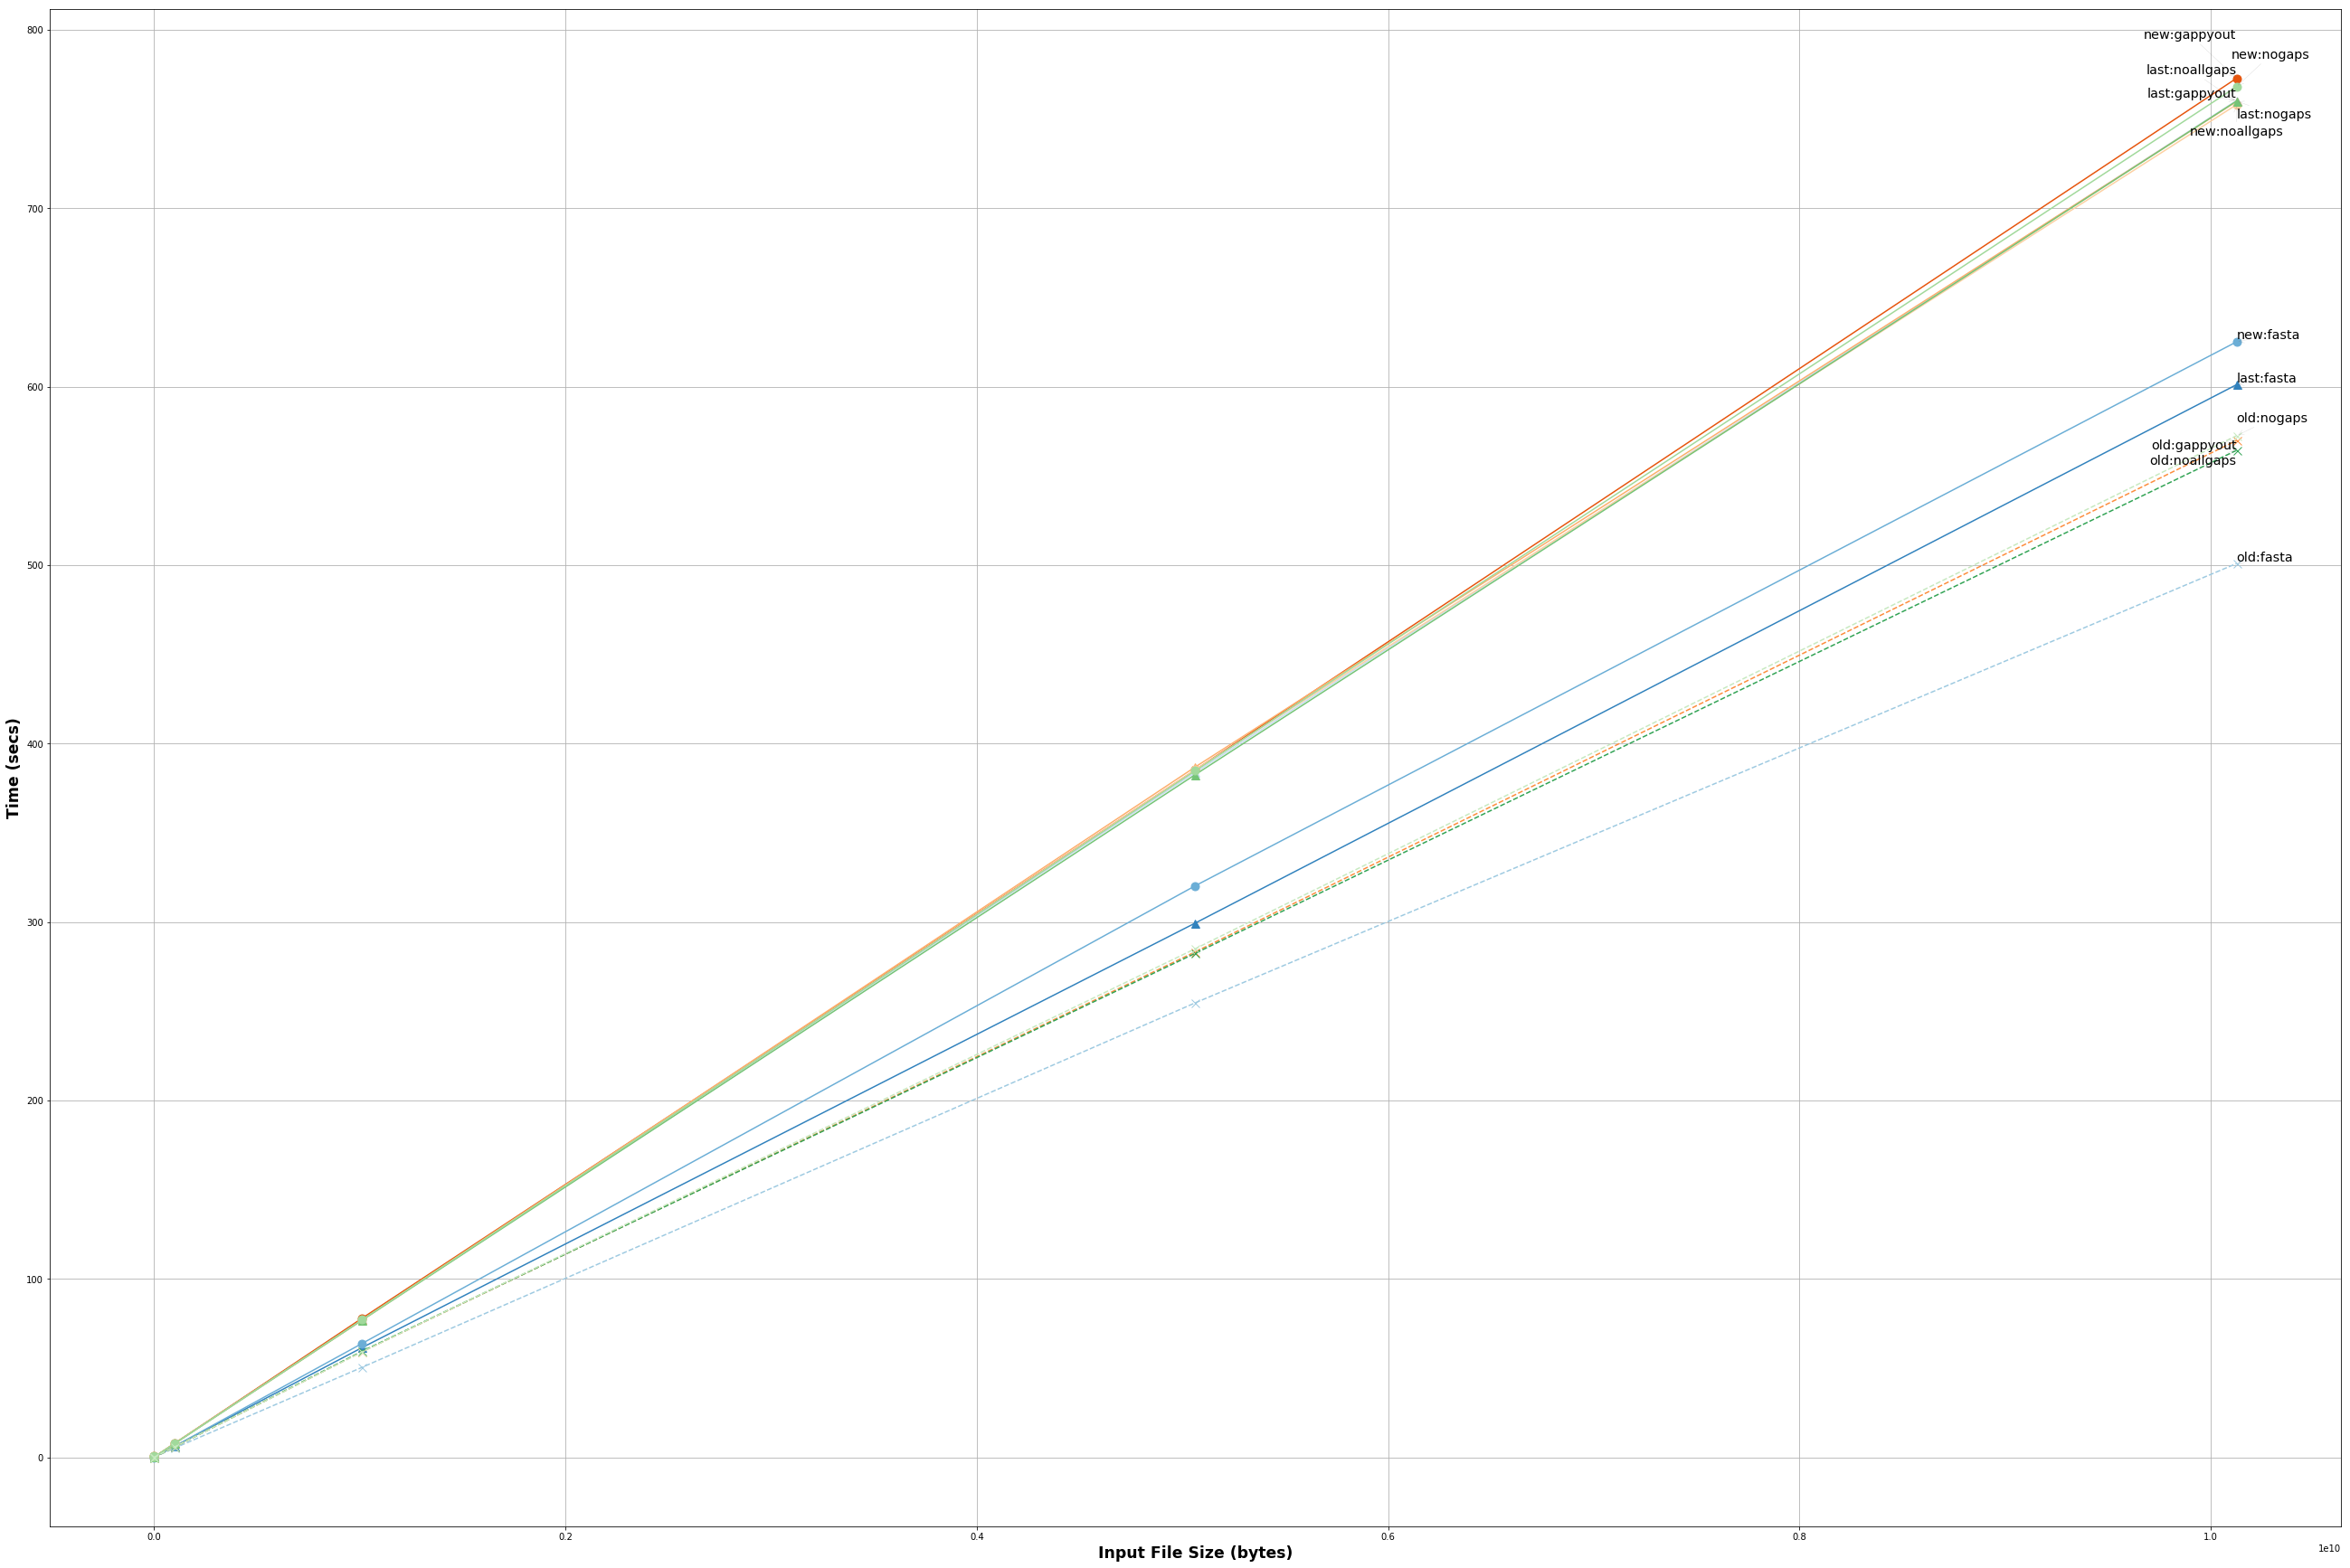

In [44]:
detected_methods = sorted(data)
detected_sizes = sorted(detected_sizes)
detected_tags = sorted(set([e for m in data for e in data[m]]))
plt.interactive(True)

fig = plt.figure(figsize = (36, 24))
ax = fig.add_subplot(111)

num_lines = len(detected_methods) * len(detected_tags)
colors = [plt.cm.Vega20c(i) for i in np.linspace(0, 1, num_lines)]
ax.set_prop_cycle(cycler('color', colors))

added_text = []

toPlot = [
 'fasta',
 'gappyout',
 'noallgaps',
 'nogaps',
]

for method in toPlot:
    for tag in detected_tags:
        if not tag in data[method]:
            continue
        y = [data[method][tag][size][0] for size in detected_sizes if size in data[method][tag]]
        x = [size for size in detected_sizes if size in data[method][tag]]
        

        ## Remove possible crashes from the detected filesizes.
        for pos in range(len(y)-1, 1, -1):
            if y[pos] * 1.1 < y[pos-1]:
                print ("%-12s\t%-4s\tpos:%-3d\t%-8s\t%2.4f secs\tpos:%-3d\t%-8s\t%2.4f secs") % \
                    (method, tag, pos-1, '{:.2e}'.format(x[pos-1]), y[pos-1], pos, '{:.2e}'.format(x[pos]), y[pos])
                x.pop(pos)
                y.pop(pos)
        
                
        sign = "o-" if tag == "new" else "x--" if tag == "old" else "^-"
        ax.plot(x, y, sign, ms = 9) #~ , label = ("%s:%s") % (tag, method))
        added_text.append(ax.text(x[-1], y[-1], ("%s:%s") % (tag, method), fontsize = "x-large"))

ax.grid(True, zorder=5)

legend = ax.legend(shadow = True, fancybox = True, ncol = 2)


ax.set_ylabel("Time (secs)", fontsize = "xx-large", fontweight = "bold")
ax.set_xlabel("Input File Size (bytes)", fontsize = "xx-large", fontweight = "bold")

adjust_text(added_text, autoalign = 'xy', expand_objects = (0.1, 1), text_from_points = False,
            only_move = {'text':'y', 'objects':'xy'},
            force_text = 0.75, force_objects = 0.1,
            arrowprops = dict(arrowstyle="->", color='gray', lw = 0.5, alpha = 0.25))


plt.tight_layout(pad = 0.4)

fig.show()
plt.savefig("/tmp/example.png", dpi = 200)

In [55]:
for method in toPlot:
    for tag in detected_tags:
        print "Method: {} \t".format(method)
        print "Tag: {} \t".format(tag)
        if not tag in data[method]:
            continue
        y = [data[method][tag][size][0] for size in detected_sizes if size in data[method][tag]]
        x = [size for size in detected_sizes if size in data[method][tag]]
        
        for i in range(0, len(x)):
            print "{:>12}  {:>12}".format(x[i], y[i])
        print " "
        
        

Method: fasta 	
Tag: last 	
       10550         0.723
     1012900         0.062
   101250400          6.19
  1012500400        61.505
  5062500400       299.413
 10125000400       601.151
 
Method: fasta 	
Tag: new 	
       10550         0.027
     1012900         0.077
   101250400         6.243
  1012500400        63.825
  5062500400       320.306
 10125000400       625.174
 
Method: fasta 	
Tag: old 	
       10550          0.06
     1012900          0.05
   101250400         5.215
  1012500400        50.446
  5062500400       254.709
 10125000400        500.92
 
Method: gappyout 	
Tag: last 	
       10550         0.744
     1012900         0.077
   101250400         7.718
  1012500400        77.597
  5062500400       383.848
 10125000400       760.423
 
Method: gappyout 	
Tag: new 	
       10550         0.723
     1012900         0.077
   101250400         7.848
  1012500400        77.974
  5062500400       385.232
 10125000400       772.898
 
Method: gappyout 	
Tag: old 	
       

In [86]:
yValues = {}

for method in toPlot:
    print "{:>12} {:>12} {:>12} {:>12} {:>12} {:>12} {:>12}".format(
                                                method.upper(), 
                                                detected_tags[0].upper(), 
                                                detected_tags[1].upper(), 
                                                detected_tags[2].upper(), "LAST/OLD", "NEW/OLD", "LAST/NEW")
    for tag in detected_tags:
        if not tag in data[method]:
            continue
        yValues[tag] = [data[method][tag][size][0] for size in detected_sizes if size in data[method][tag]]
    for i in range(0, len(x)):
            r0 = yValues[detected_tags[0]][i]/yValues[detected_tags[2]][i]
            r1 = yValues[detected_tags[1]][i]/yValues[detected_tags[2]][i]
            r2 = yValues[detected_tags[0]][i]/yValues[detected_tags[1]][i]
            print "{:>12} {:>12} {:>12} {:>12} {:>12.2f}x {:>12.2f}x {:>12.2f}x".format(
                                                        x[i], 
                                                        yValues[detected_tags[0]][i], 
                                                        yValues[detected_tags[1]][i],
                                                        yValues[detected_tags[2]][i],
            r0, r1, r2)
    print " "


       FASTA         LAST          NEW          OLD     LAST/OLD      NEW/OLD     LAST/NEW
       10550        0.723        0.027         0.06        12.05x         0.45x        26.78x
     1012900        0.062        0.077         0.05         1.24x         1.54x         0.81x
   101250400         6.19        6.243        5.215         1.19x         1.20x         0.99x
  1012500400       61.505       63.825       50.446         1.22x         1.27x         0.96x
  5062500400      299.413      320.306      254.709         1.18x         1.26x         0.93x
 10125000400      601.151      625.174       500.92         1.20x         1.25x         0.96x
 
    GAPPYOUT         LAST          NEW          OLD     LAST/OLD      NEW/OLD     LAST/NEW
       10550        0.744        0.723        0.002       372.00x       361.50x         1.03x
     1012900        0.077        0.077        0.061         1.26x         1.26x         1.00x
   101250400        7.718        7.848        5.845         1.32